# IBM Developer Example

[Using foundation models for time series forecasting](https://developer.ibm.com/tutorials/awb-foundation-model-time-series-forecasting/)

In [2]:
import os
import math
import tempfile
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# TSFM libraries
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback

## Step1. Import the libraries

In [3]:
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd

# TSFM libraries
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback

## Step 2. Load the data

In [4]:
pollution_data = pd.read_csv(
    "/Users/thomassuedbroecker/Documents/tsuedbro/dev/granite-tsfm/notebooks/example/PRSA_data_2010.1.1-2014.12.31.csv"
)
pollution_data.head(3)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0


## Step 3. Add date column

In [5]:
timestamp_column = "date"
target_columns = ["pm2.5"]
observable_columns = ["DEWP","TEMP","PRES", "Iws"]
pollution_data['date'] = pd.to_datetime(pollution_data[['year','month','day', 'hour']])
pollution_data.head(3)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,date
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00


In [6]:
#deal with NA
pollution_data['pm2.5'] = pollution_data['pm2.5'].interpolate()
pollution_data['pm2.5'].head(3)

0   NaN
1   NaN
2   NaN
Name: pm2.5, dtype: float64

<Axes: xlabel='date'>

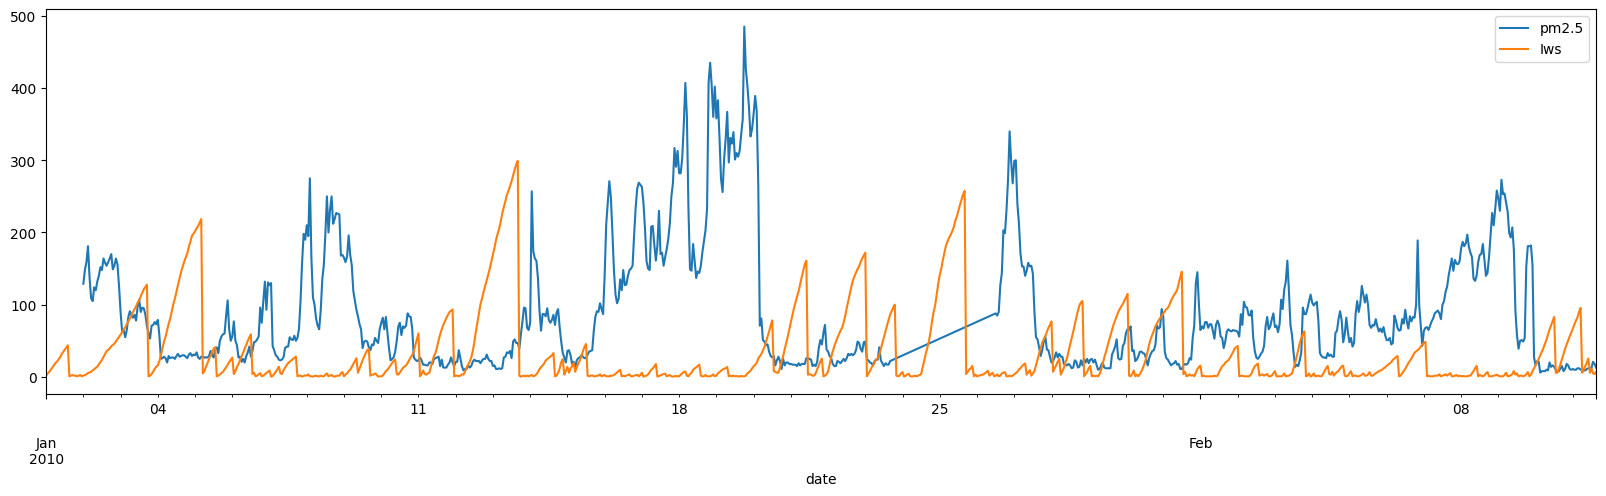

In [7]:
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html
pollution_data[:1000].plot(x="date", y=["pm2.5", "Iws"], figsize=(20,5))

## Step 4: Prepare the data

In [25]:
# Set seed for reproducibility

SEED = 42
set_seed(SEED)

# Results dir
OUT_DIR = "/Users/thomassuedbroecker/Documents/tsuedbro/dev/granite-tsfm/notebooks/example/ttm_finetuned_models/"

# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "main"


# Forecasting parameters
context_length = 512 # TTM can use 512 time points into the past
forecast_length = 96 # TTM can predict 96 time points into the future
fewshot_fraction = 0.05

In [9]:
from tsfm_public import (
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
    get_datasets,
)

data_length = len(pollution_data)

train_start_index = 0
train_end_index = round(data_length * 0.8)
print(f"data_length:\n{data_length}\ntrain_start_index:\n{train_start_index}\ntrain_end_index\n{train_end_index}")

data_length:
43824
train_start_index:
0
train_end_index
35059


In [10]:
# we shift the start of the evaluation period back by context length so that
# the first evaluation timestamp is immediately following the training data
eval_start_index = round(data_length * 0.8) - context_length
eval_end_index = round(data_length * 0.9)
print(f"eval_start_index:\n{eval_start_index}\neval_end_index:\n{eval_end_index}\n")

eval_start_index:
34547
eval_end_index:
39442



In [11]:
test_start_index = round(data_length * 0.9) - context_length
test_end_index = data_length
print(f"test_start_index:\n{test_start_index}\ntest_end_index:\n{test_end_index}\n")

test_start_index:
38930
test_end_index:
43824



In [12]:
split_config = {
                "train": [0, train_end_index],
                "valid": [eval_start_index, eval_end_index],
                "test": [test_start_index,test_end_index],
            }

In [13]:
column_specifiers = {
    "timestamp_column": timestamp_column,
    "target_columns": target_columns,
    "observable_columns": observable_columns
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=True,
    scaler_type="standard",
)

# this gets torch vectors for training. For test eval we need a Pandas DF
train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, pollution_data, split_config
)

In [14]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision="main", prediction_filter_length=24)

# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
)

zeroshot_trainer.evaluate(test_dataset)  #note that this is the Torch dataset created by get_datasets(), not a Pandas DataFrame

{'eval_loss': 0.29865384101867676,
 'eval_model_preparation_time': 0.0007,
 'eval_runtime': 5.9832,
 'eval_samples_per_second': 802.084,
 'eval_steps_per_second': 100.281}

## Step 5. Use the TTM model for forecasting

In [15]:
from tsfm_public.toolkit.util import select_by_index
from tsfm_public.toolkit.time_series_forecasting_pipeline import TimeSeriesForecastingPipeline
from tsfm_public.toolkit.visualization import plot_ts_forecasting

zs_forecast_pipeline = TimeSeriesForecastingPipeline(
    model=zeroshot_model,
    device="cpu",
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    freq="1h"
)

In [16]:
zs_forecast = zs_forecast_pipeline(tsp.preprocess(pollution_data[test_start_index:test_end_index]))

In [17]:
zs_forecast.head(3)

,date,pm2.5_prediction,pm2.5
0,2014-07-02 09:00:00,"[-0.48461461067199707, -0.47305673360824585, -...","[-0.7239559292793274, -0.5355687737464905, -0...."
1,2014-07-02 10:00:00,"[-0.6441084146499634, -0.6066262722015381, -0....","[-0.5355687737464905, -0.4690791666507721, -0...."
2,2014-07-02 11:00:00,"[-0.5099279284477234, -0.4922369718551636, -0....","[-0.4690791666507721, -0.3804263770580292, -0...."


<Axes: >

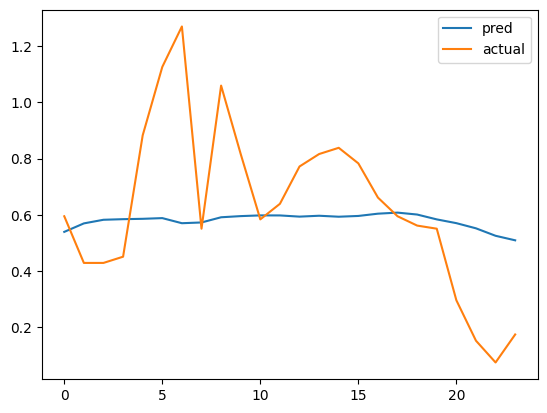

In [18]:
fcast_df = pd.DataFrame({"pred":zs_forecast.loc[50]['pm2.5_prediction'], "actual":zs_forecast.loc[50]['pm2.5'][:24]})
fcast_df.plot()

## Step 6. Evaluating the forecast results

In [19]:
def compare_forecast(forecast, date_col, prediction_col, actual_col, hours_out):
  comparisons = pd.DataFrame()
  comparisons[date_col] = forecast[date_col]
  actual = []
  pred = []

  for i in range(len(forecast)):
    pred.append(forecast[prediction_col].values[i][hours_out - 1]) # prediction for next day
    actual.append(forecast[actual_col].values[i][hours_out - 1])

  comparisons['actual'] = actual
  comparisons['pred'] = pred

  return comparisons

/Users/thomassuedbroecker/Documents/tsuedbro/dev/granite-tsfm/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


<Axes: title={'center': '0.8188841961'}, xlabel='date'>

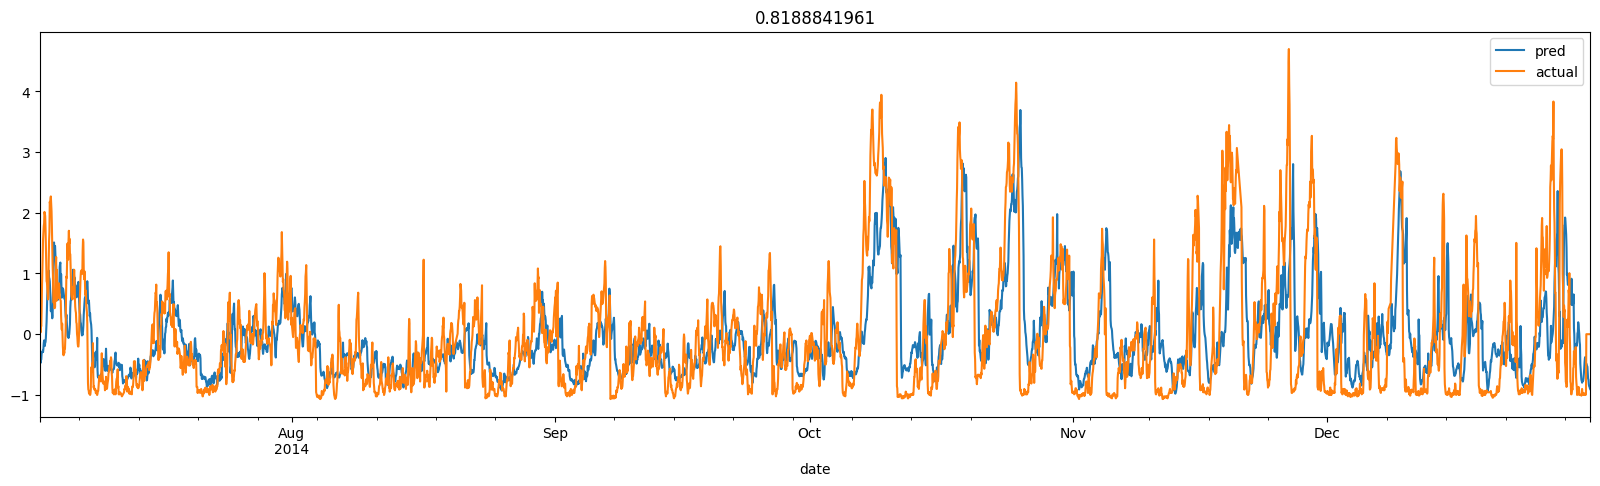

In [20]:
one_day_out_predictions = compare_forecast(zs_forecast, "date", "pm2.5_prediction", "pm2.5", 12)

out = one_day_out_predictions[[not np.isnan(x).any() for x in one_day_out_predictions['actual']]]

rms = '{:.10f}'.format(mean_squared_error(one_day_out_predictions['actual'], one_day_out_predictions['pred'], squared=False))
one_day_out_predictions.plot(x="date", y=["pred", "actual"], figsize=(20,5), title=str(rms))

## Step 9. Fine tuning the TTM model

In [ ]:
fffff

In [27]:
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm/TTM", revision=TTM_MODEL_REVISION, prediction_filter_length=24
)

In [21]:
# Important parameters
learning_rate = 0.001
num_epochs = 20
batch_size = 32

finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
)

/Users/thomassuedbroecker/Documents/tsuedbro/dev/granite-tsfm/.venv/lib/python3.12/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=2,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.001,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

In [28]:
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

In [29]:
finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

INFO:p-68112:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-68162:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-68165:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-68174:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-68183:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-68226:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-68229:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-68230:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.


Epoch,Training Loss,Validation Loss
1,0.307800,0.289122
2,0.286000,0.279817
3,0.271700,0.278911
4,0.264700,0.280417


INFO:p-69642:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-69684:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-69722:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-69728:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-69777:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-69780:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-69789:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-69790:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-70376:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-70391:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-70394:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-70435:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-70460:t-8226066240:config.py:<module>:PyTorch version 2.4

[TrackingCallback] Mean Epoch Time = 114.99411594867706 seconds, Total Train Time = 677.236572265625


TrainOutput(global_step=4308, training_loss=0.2825483501012832, metrics={'train_runtime': 677.2375, 'train_samples_per_second': 1017.427, 'train_steps_per_second': 31.806, 'total_flos': 1704561043046400.0, 'train_loss': 0.2825483501012832, 'epoch': 4.0})

## Step 10. Evaluating the fine-tuned TTM model

In [33]:
finetune_forecast_trainer.evaluate(test_dataset) #note that this is the torch dataset, not a Pandas DataFrame

INFO:p-90073:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-90098:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-90134:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-90165:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-90166:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-90215:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-90218:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-90227:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.


RuntimeError: Tensor for argument weight is on cpu but expected on mps

In [ ]:
test_data = tsp.preprocess(pollution_data[test_start_index:test_end_index])

In [ ]:
test_data = tsp.preprocess(pollution_data[test_start_index:test_end_index])

In [32]:
forecast_pipeline = TimeSeriesForecastingPipeline(
    model=finetune_forecast_model,
    device="cpu",
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    observable_columns=observable_columns,
    freq="1h"
)

forecasts = forecast_pipeline(test_data)

fcast_df = pd.DataFrame({"pred":forecasts.loc[50]['pm2.5_prediction'], "actual":forecasts.loc[50]['pm2.5'][:24]})
fcast_df.plot()

NameError: name 'test_data' is not defined

In [34]:
test_data = tsp.preprocess(pollution_data[test_start_index:test_end_index])